# Trying to make a PINN to predict the motion of a simple pendulum.
### Needs some steps
1. Assuming some constants like length, g, and stuff like w calculation.
2. Also setting initial states.
3. Creating dataset. Using actual solution as the training data basically.
4. Then creating the PINN by overwriting the nn.Module class.
5. Create loss functions for data loss, physics loss and initial condition loss. The PINN would have to minimise these three as a total loss therefore adhering to the data, the two coupled ODEs and initial condition as well. We are trying to predict both theta and omega.
6. Start computing and every once in a while, show loss.

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [ ]:
#constants
L = 1 #meter
g = 9.81 #m/s**2
w = (g/L)**0.5
k = g/L
T = 2 * 3.14 * (L/g)**0.5
T_2 = T/2
B = 0.0
print(k, T, T_2)

9.81 2.005049690396277 1.0025248451981386


In [ ]:
#initial conditions
initial_conditions = [0.785, 0.0] #initially, theta = 45 degrees and angular velocity = 0

#okay so to test basicaly, we'll take an array of initial conditions in multiples of

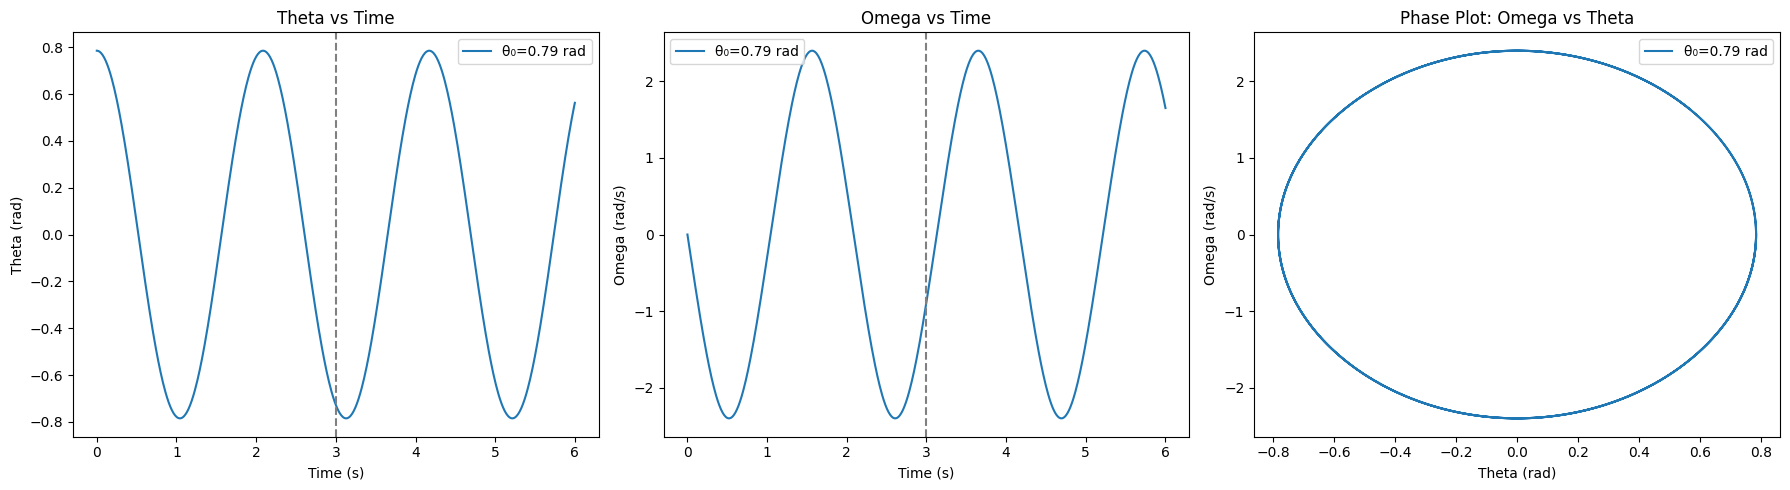

In [ ]:
# Time space configuration
start_time = 0.0
end_time = 6.0
points_per_second = 100
num_points = int((end_time - start_time) * points_per_second)
time_points = torch.linspace(start_time, end_time, num_points, requires_grad=True).view(-1, 1)

# Constants
L = 1.0      # Length of pendulum
g = 9.81     # Acceleration due to gravity
k = g / L    # Constant used in the equation

# Define the simple pendulum equation
def simple_pendulum_eqn(state, t, L, g, k):
    theta, theta_dot = state[0], state[1]
    theta_ddot = -k * np.sin(theta) - B * theta_dot
    return theta_dot, theta_ddot

# List of initial theta values (in radians), with omega = 0 for all
initial_theta_list = [0.785]

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

for theta_0 in initial_theta_list:
    initial_conditions = [theta_0, 0.0]
    states = odeint(simple_pendulum_eqn, y0=initial_conditions, t=time_points.detach().view(-1), args=(L, g, k))
    THETA = torch.tensor(states[:, 0], dtype=torch.float32).view(-1, 1)
    OMEGA = torch.tensor(states[:, 1], dtype=torch.float32).view(-1, 1)

    label = f"θ₀={theta_0:.2f} rad"
    ax1.plot(time_points.detach(), THETA, label=label)
    ax2.plot(time_points.detach(), OMEGA, label=label)
    ax3.plot(THETA, OMEGA, label=label)

# Customize plots
ax1.axvline(x=3.0, color='gray', linestyle='--')
ax2.axvline(x=3.0, color='gray', linestyle='--')

ax1.set_title("Theta vs Time")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Theta (rad)")
ax1.legend()

ax2.set_title("Omega vs Time")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Omega (rad/s)")
ax2.legend()

ax3.set_title("Phase Plot: Omega vs Theta")
ax3.set_xlabel("Theta (rad)")
ax3.set_ylabel("Omega (rad/s)")
ax3.legend()

plt.tight_layout()

plt.savefig('reals.png')
plt.show()


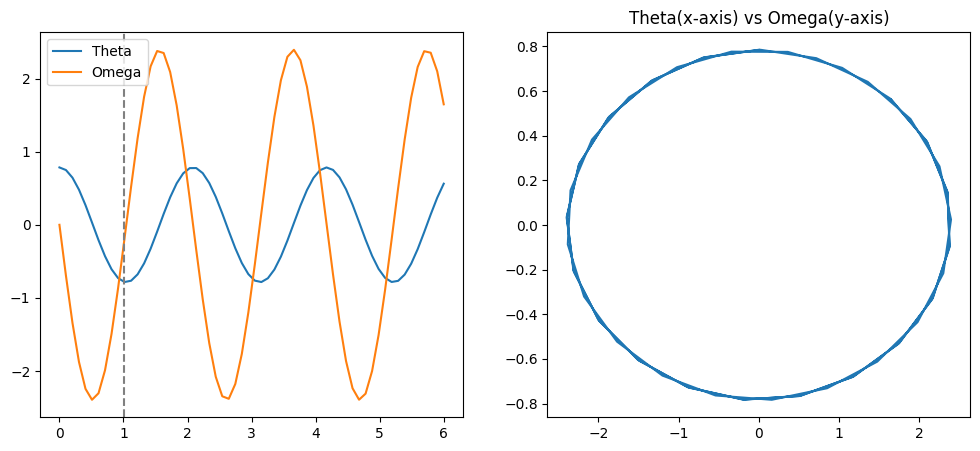

In [ ]:
#more data for extra security
time_points_extra = torch.linspace(start_time, end_time, int(num_points*0.1), requires_grad=True).view(-1, 1) #just 10%

states_extra = odeint(simple_pendulum_eqn, y0=initial_conditions, t=time_points_extra.detach().view(-1), args=(L, g, k))
THETA_extra = torch.tensor(states_extra[:, 0], dtype=torch.float32).view(-1, 1)
OMEGA_extra = torch.tensor(states_extra[:, 1], dtype=torch.float32).view(-1, 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(time_points_extra.detach(), THETA_extra)
ax[0].plot(time_points_extra.detach(), OMEGA_extra)
ax[0].axvline(x=T_2, color='gray', linestyle='--')  # line at halfway point
ax[0].legend(["Theta","Omega"])

ax[1].plot(OMEGA_extra, THETA_extra)
ax[1].set_title("Theta(x-axis) vs Omega(y-axis)")

plt.show()

In [ ]:
#creating PINN
class SinActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)

class PendulumSolver(nn.Module):
  def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS, N_OUTPUT):
    super().__init__()
    activation = SinActivation

    layers = [nn.Linear(N_INPUT, N_HIDDEN), activation()] #initialy contains just the 1 layer
    for _ in range(N_LAYERS-1):
      layers.append(nn.Linear(N_HIDDEN, N_HIDDEN)) #adding n-1 layers and n-1 activation functions as well.
      layers.append(activation())
    layers.append(nn.Linear(N_HIDDEN, N_OUTPUT)) #final output layer - doesn't need the activation function (I hope).

    self.net = nn.Sequential(*layers) #unpacking all contents of layers into sequential.

  def forward(self, T):
    output = self.net(T)
    theta = output[:, 0:1]
    omega = output[:, 1:2]
    return theta, omega

In [ ]:
def loss_fn(theta_predicted, theta_true, omega_predicted, omega_true, time_points, use_data=False):
  #Data loss
  data_loss = torch.mean((theta_predicted-theta_true)**2) + torch.mean((omega_predicted-omega_true)**2)

  #Physics loss
  dtheta_dt = torch.autograd.grad(theta_predicted, time_points, torch.ones_like(theta_predicted), create_graph=True)[0] #dtheta/dt
  coupled_eqn2 = dtheta_dt - omega_predicted
  eqn2_loss = torch.mean(coupled_eqn2**2)


  d2theta_dt2 = torch.autograd.grad(omega_predicted, time_points, torch.ones_like(omega_predicted), create_graph = True)[0] #d^2theta/dt^2
  coupled_eqn1 = d2theta_dt2 + k*torch.sin(theta_predicted) + B * omega_predicted
  eqn1_loss = torch.mean(coupled_eqn1**2)

  physics_loss = eqn1_loss + eqn2_loss

  #initial conditions loss
  theta0 = torch.tensor([[initial_conditions[0]]], dtype = torch.float32).view(-1, 1) #initial conditions as theta = pi/4 and omega = 1
  omega0 = torch.tensor([[initial_conditions[1]]], dtype = torch.float32).view(-1, 1)

  t0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad = True)
  theta_init_pred, omega_init_pred = model(t0)


  init_cond_loss = torch.mean((theta_init_pred - theta0)**2) + torch.mean((omega_init_pred - omega0)**2)


  #if we want to use data loss, we have to specify it as true or false, default is false.
  if use_data:
    return data_loss, data_loss + physics_loss + init_cond_loss
  else:
    return data_loss, physics_loss + init_cond_loss


In [ ]:

#start running the epochs and computing values.
model = PendulumSolver(1, 64, 3, 2)
optimiser = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
OverallLoss = []

In [ ]:
epochs = int(end_time-start_time)*1000#original x1000

final_theta_physics, final_omega_physics = None, None

for epoch in range(epochs):
  optimiser.zero_grad() #reset optimiser every epoch

  theta_predicted, omega_predicted = model(time_points)
  dloss, loss = loss_fn(theta_predicted, THETA, omega_predicted, OMEGA, time_points)

  #backpropogation
  OverallLoss.append(loss.item())
  loss.backward()

  optimiser.step()

  #printing loss every once in a while
  if ((epoch+1)%10==0):
    print(f"Epoch {epoch+1} - Total loss : {loss.item():.6f}, data_loss (not minimised) : {dloss.item():.6f}")

  if((epoch+1)%epochs == 0):
    final_theta = theta_predicted.detach()
    final_omega = omega_predicted.detach()



Epoch 10 - Total loss : 0.911563, data_loss (not minimised) : 3.181818
Epoch 20 - Total loss : 0.765662, data_loss (not minimised) : 3.183837
Epoch 30 - Total loss : 0.574721, data_loss (not minimised) : 3.193559
Epoch 40 - Total loss : 0.523175, data_loss (not minimised) : 3.196579
Epoch 50 - Total loss : 0.522160, data_loss (not minimised) : 3.199969
Epoch 60 - Total loss : 0.514033, data_loss (not minimised) : 3.204972
Epoch 70 - Total loss : 0.504690, data_loss (not minimised) : 3.210889
Epoch 80 - Total loss : 0.499314, data_loss (not minimised) : 3.216927
Epoch 90 - Total loss : 0.492924, data_loss (not minimised) : 3.223004
Epoch 100 - Total loss : 0.487020, data_loss (not minimised) : 3.229346
Epoch 110 - Total loss : 0.480846, data_loss (not minimised) : 3.235793
Epoch 120 - Total loss : 0.474431, data_loss (not minimised) : 3.242459
Epoch 130 - Total loss : 0.467614, data_loss (not minimised) : 3.249235
Epoch 140 - Total loss : 0.460205, data_loss (not minimised) : 3.255952
E

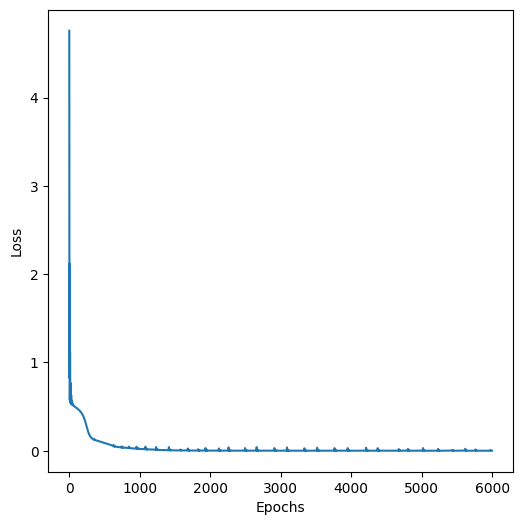

In [ ]:
EPOCHS = [i for i in range(epochs)]
plt.figure(figsize=(6,6))
plt.plot(EPOCHS, OverallLoss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('epochs.png')
plt.show()

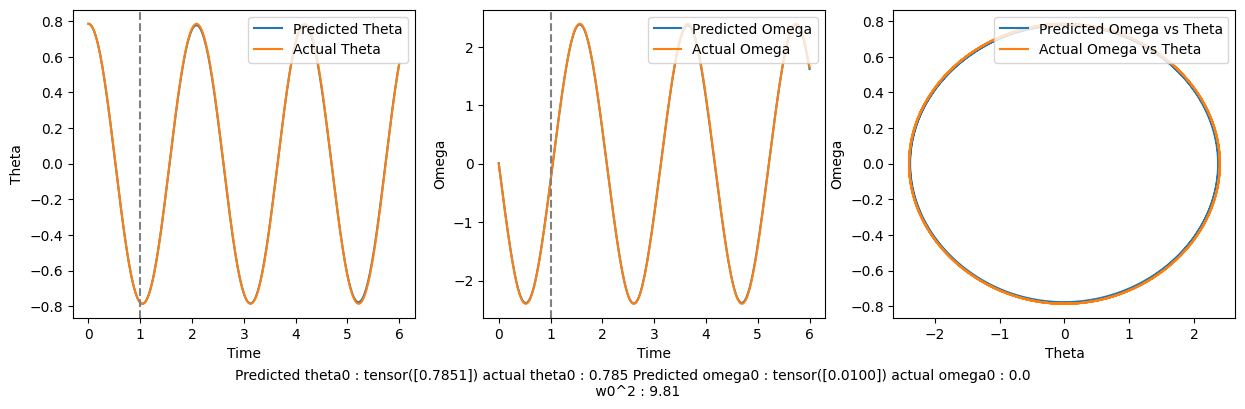

Predicted theta0 : tensor([0.7851]) actual theta0 : 0.785
Predicted omega0 : tensor([0.0100]) actual omega0 : 0.0
w0^2 : 9.81


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))

ax[0].plot(time_points.detach(), final_theta)
ax[0].plot(time_points.detach(), THETA)
ax[0].axvline(x=T_2, color='gray', linestyle='--')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Theta')
ax[0].legend(['Predicted Theta','Actual Theta'], loc = 'upper right')

ax[1].plot(time_points.detach(), final_omega)
ax[1].plot(time_points.detach(), OMEGA)
ax[1].axvline(x=T_2, color='gray', linestyle='--')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Omega')
ax[1].legend(['Predicted Omega','Actual Omega'], loc = 'upper right')

ax[2].plot(final_omega, final_theta)
ax[2].plot(OMEGA, THETA)
ax[2].set_xlabel('Theta')
ax[2].set_ylabel('Omega')
ax[2].legend(['Predicted Omega vs Theta', 'Actual Omega vs Theta'], loc = 'upper right')

console_text = f"Predicted theta0 : {final_theta[0]} actual theta0 : {initial_conditions[0]} Predicted omega0 : {final_omega[0]} actual omega0 : {initial_conditions[1]} \n w0^2 : {k}"
plt.figtext(0.5, -0.08, console_text, wrap=True, horizontalalignment='center', fontsize=10)

plt.savefig('3.png', bbox_inches='tight')

plt.show()

print(f"Predicted theta0 : {final_theta[0]} actual theta0 : {initial_conditions[0]}")
print(f"Predicted omega0 : {final_omega[0]} actual omega0 : {initial_conditions[1]}")
print(f"w0^2 : {k}")

In [ ]:
console_text = f"Predicted theta0 : {final_theta[0]} actual theta0 : {initial_conditions[0]} Predicted omega0 : {final_omega[0]} actual omega0 : {initial_conditions[1]} \n w0^2 : {k}"

In [ ]:
console_text

'Predicted theta0 : tensor([0.7851]) actual theta0 : 0.785 Predicted omega0 : tensor([0.0100]) actual omega0 : 0.0 \n w0^2 : 9.81'